In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv('data/application_record_joined.csv')

# Data Preprocessing and Encoding

#### 📦 Grouping Rare Categories in Categorical Features
To reduce the complexity and sparsity of categorical data, we grouped infrequent categories into a single label, "Other". This is especially useful when dealing with high-cardinality features, which can otherwise dilute patterns during modeling.

NAME_INCOME_TYPE: Categories with fewer than 100 instances were grouped as "Other".

NAME_FAMILY_STATUS: Similarly, rare statuses under 100 occurrences were combined.

OCCUPATION_TYPE: Occupations occurring less than 200 times were replaced with "Other".

This helps improve the generalization of models and reduces noise from rarely seen levels.

In [6]:
# Group rare levels in NAME_INCOME_TYPE
income_type_counts = df["NAME_INCOME_TYPE"].value_counts()
rare_income_types = income_type_counts[income_type_counts < 100].index
df["NAME_INCOME_TYPE_REDUCED"] = df["NAME_INCOME_TYPE"].replace(rare_income_types, "Other")

# Group rare levels in NAME_FAMILY_STATUS
family_status_counts = df["NAME_FAMILY_STATUS"].value_counts()
rare_family_statuses = family_status_counts[family_status_counts < 100].index
df["NAME_FAMILY_STATUS_REDUCED"] = df["NAME_FAMILY_STATUS"].replace(rare_family_statuses, "Other")

# Cluster rare occupations in OCCUPATION_TYPE into "Other"
occupation_counts = df["OCCUPATION_TYPE"].value_counts()
rare_occupations = occupation_counts[occupation_counts < 200].index
df["OCCUPATION_TYPE_REDUCED"] = df["OCCUPATION_TYPE"].replace(rare_occupations, "Other")

# Summarize reduced category distributions
income_type_summary = df["NAME_INCOME_TYPE_REDUCED"].value_counts()
family_status_summary = df["NAME_FAMILY_STATUS_REDUCED"].value_counts()
occupation_summary = df["OCCUPATION_TYPE_REDUCED"].value_counts()

income_type_summary, family_status_summary, occupation_summary

(NAME_INCOME_TYPE_REDUCED
 Working                 18819
 Commercial associate     8490
 Pensioner                6152
 State servant            2985
 Other                      11
 Name: count, dtype: int64,
 NAME_FAMILY_STATUS_REDUCED
 Married                 25048
 Single / not married     4829
 Civil marriage           2945
 Separated                2103
 Widow                    1532
 Name: count, dtype: int64,
 OCCUPATION_TYPE_REDUCED
 Laborers                 6211
 Core staff               3591
 Sales staff              3485
 Managers                 3012
 Drivers                  2138
 High skill tech staff    1383
 Accountants              1241
 Medicine staff           1207
 Other                     724
 Cooking staff             655
 Security staff            592
 Cleaning staff            551
 Private service staff     344
 Name: count, dtype: int64)

#### 🔁 Converting Boolean Flags to Binary
We converted text-based flags to binary format:

FLAG_OWN_CAR: 'Y' → 1, 'N' → 0

FLAG_OWN_REALTY: 'Y' → 1, 'N' → 0

This transformation is essential to prepare the data for machine learning algorithms that expect numeric inputs.

In [7]:
# Convert boolean-like columns to 0/1
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

#### 📅 Transforming Day-Based Features into Years
We transformed duration-based columns from days into more interpretable year values:

DAYS_BIRTH → YEARS_BIRTH

DAYS_EMPLOYED → YEARS_EMPLOYED

To ensure consistency, we also replaced values less than 1 with 1 to avoid nonsensical values like zero or negative age/employment durations.

In [8]:
# Convert DAYS_BIRTH and DAYS_EMPLOYED into years
df['YEARS_BIRTH'] = (-df['DAYS_BIRTH'] // 365)
df['YEARS_EMPLOYED'] = (-df['DAYS_EMPLOYED'] // 365)

# Replace years less than 1 with 1 year
df['YEARS_BIRTH'] = df['YEARS_BIRTH'].apply(lambda x: max(x, 1))
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].apply(lambda x: max(x, 1))



#### 🧠 Imputing Missing Occupation Types by Education Level
Missing values in OCCUPATION_TYPE_REDUCED were imputed based on the most frequent (mode) occupation within the same NAME_EDUCATION_TYPE group. If no mode existed, it defaulted to "Other". This method leverages domain-specific groupings to fill in missing categorical data more intelligently.

In [9]:
# Example of mode imputation based on education level:
df["OCCUPATION_TYPE_REDUCED"] = df.groupby("NAME_EDUCATION_TYPE")["OCCUPATION_TYPE_REDUCED"].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Other")
)
df.head()

,ID,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_REDUCED,NAME_FAMILY_STATUS_REDUCED,OCCUPATION_TYPE_REDUCED,YEARS_BIRTH,YEARS_EMPLOYED
0,5008804,0,M,1,1,0,427500.0,Working,Higher education,Civil marriage,...,1,0,0,NaN,2.0,Working,Civil marriage,Managers,32,12
1,5008805,0,M,1,1,0,427500.0,Working,Higher education,Civil marriage,...,1,0,0,NaN,2.0,Working,Civil marriage,Managers,32,12
2,5008806,0,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,...,0,0,0,Security staff,2.0,Working,Married,Security staff,58,3
3,5008808,0,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,...,0,1,1,Sales staff,1.0,Commercial associate,Single / not married,Sales staff,52,8
4,5008809,0,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,...,0,1,1,Sales staff,1.0,Commercial associate,Single / not married,Sales staff,52,8


#### 🧹 Dropping Redundant or Unnecessary Columns
We dropped columns that were either:

Duplicative or highly correlated with transformed versions (e.g., DAYS_BIRTH)

Low information (e.g., FLAG_PHONE, FLAG_EMAIL)

Potential data leakages or identifiers (e.g., ID, CODE_GENDER)

This step reduces noise and simplifies the feature space.

In [10]:
df = df.drop(columns=['ID', 'CODE_GENDER', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'NAME_FAMILY_STATUS',  'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED' ])
df.head()

,STATUS,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_REDUCED,NAME_FAMILY_STATUS_REDUCED,OCCUPATION_TYPE_REDUCED,YEARS_BIRTH,YEARS_EMPLOYED
0,0,1,1,0,427500.0,Higher education,Rented apartment,2.0,Working,Civil marriage,Managers,32,12
1,0,1,1,0,427500.0,Higher education,Rented apartment,2.0,Working,Civil marriage,Managers,32,12
2,0,1,1,0,112500.0,Secondary / secondary special,House / apartment,2.0,Working,Married,Security staff,58,3
3,0,0,1,0,270000.0,Secondary / secondary special,House / apartment,1.0,Commercial associate,Single / not married,Sales staff,52,8
4,0,0,1,0,270000.0,Secondary / secondary special,House / apartment,1.0,Commercial associate,Single / not married,Sales staff,52,8


#### 🧵 Identifying Categorical Features
We selected all features with object datatype, marking them as categorical features to be encoded in the next step.

In [11]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features  

['NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE_REDUCED',
 'NAME_FAMILY_STATUS_REDUCED',
 'OCCUPATION_TYPE_REDUCED']

#### ✅ Checking Target Variable Values
We examined the unique values of the STATUS column to ensure it is suitable as a target for supervised learning. This helps validate that the column behaves as expected.

In [12]:
# Check if 'STATUS' is suitable for use as a target
status_values = df['STATUS'].unique()
status_values 

array([0, 1], dtype=int64)

#### 🎯 Target Encoding of Categorical Variables
We applied target encoding to categorical variables. For each category in a feature:

Calculated the mean target value (STATUS) and size (count).

Computed a weighted mean that blends the group mean with the overall mean to reduce overfitting.

Created new columns prefixed with ENCODED_ for each encoded feature.

In [13]:
# Apply target encoding
for feature in categorical_features:
    target_mean = df.groupby(feature)['STATUS'].agg(['mean', 'size'])
    # Calculate the weighted mean
    target_mean['weighted_mean'] = (target_mean['mean'] * target_mean['size'] + df['STATUS'].mean()) / (target_mean['size'] + 1)
    # Map to a new column in df and round to 3 decimal points
    df[f'ENCODED_{feature}'] = df[feature].map(target_mean['weighted_mean']).round(4)

df.head()

,STATUS,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_REDUCED,NAME_FAMILY_STATUS_REDUCED,OCCUPATION_TYPE_REDUCED,YEARS_BIRTH,YEARS_EMPLOYED,ENCODED_NAME_EDUCATION_TYPE,ENCODED_NAME_HOUSING_TYPE,ENCODED_NAME_INCOME_TYPE_REDUCED,ENCODED_NAME_FAMILY_STATUS_REDUCED,ENCODED_OCCUPATION_TYPE_REDUCED
0,0,1,1,0,427500.0,Higher education,Rented apartment,2.0,Working,Civil marriage,Managers,32,12,0.0173,0.0139,0.0163,0.0156,0.0157
1,0,1,1,0,427500.0,Higher education,Rented apartment,2.0,Working,Civil marriage,Managers,32,12,0.0173,0.0139,0.0163,0.0156,0.0157
2,0,1,1,0,112500.0,Secondary / secondary special,House / apartment,2.0,Working,Married,Security staff,58,3,0.0162,0.0166,0.0163,0.0157,0.0220
3,0,0,1,0,270000.0,Secondary / secondary special,House / apartment,1.0,Commercial associate,Single / not married,Sales staff,52,8,0.0162,0.0166,0.0168,0.0209,0.0128
4,0,0,1,0,270000.0,Secondary / secondary special,House / apartment,1.0,Commercial associate,Single / not married,Sales staff,52,8,0.0162,0.0166,0.0168,0.0209,0.0128


#### 🗺️ Creating an Encoding Map for Categorical Features
To preserve the encoding logic:

We stored the mapping between original categories and their encoded values.

This map can be used for reference or future transformation of new/unseen data.

The output displays each feature’s category alongside its encoded numerical value.

In [14]:
encoding_map = {}

for feature in categorical_features:
    # Grouping to get the mean, size, and weighted mean as before
    target_mean = df.groupby(feature)['STATUS'].agg(['mean', 'size'])
    target_mean['weighted_mean'] = (target_mean['mean'] * target_mean['size'] + df['STATUS'].mean()) / (target_mean['size'] + 1)
    
    # Extracting the mapping
    encoding_map[feature] = target_mean['weighted_mean'].round(4).to_dict()  # Round to 4 decimal points

# Display the encoding map
for feature, mapping in encoding_map.items():
    print(f"## {feature}")
    for category, encoded_value in mapping.items():
        print(f"- {category}: {encoded_value}")
    print()

## NAME_EDUCATION_TYPE
- Academic degree: 0.0005
- Higher education: 0.0173
- Incomplete higher: 0.0234
- Lower secondary: 0.0267
- Secondary / secondary special: 0.0162

## NAME_HOUSING_TYPE
- Co-op apartment: 0.0179
- House / apartment: 0.0166
- Municipal apartment: 0.0266
- Office apartment: 0.0343
- Rented apartment: 0.0139
- With parents: 0.0146

## NAME_INCOME_TYPE_REDUCED
- Commercial associate: 0.0168
- Other: 0.0014
- Pensioner: 0.0211
- State servant: 0.0124
- Working: 0.0163

## NAME_FAMILY_STATUS_REDUCED
- Civil marriage: 0.0156
- Married: 0.0157
- Separated: 0.0147
- Single / not married: 0.0209
- Widow: 0.0294

## OCCUPATION_TYPE_REDUCED
- Accountants: 0.0185
- Cleaning staff: 0.0091
- Cooking staff: 0.0137
- Core staff: 0.0206
- Drivers: 0.0229
- High skill tech staff: 0.0217
- Laborers: 0.0169
- Managers: 0.0157
- Medicine staff: 0.0083
- Other: 0.0221
- Private service staff: 0.0058
- Sales staff: 0.0128
- Security staff: 0.022



#### 🧼 Final Cleanup: Removing Original Categorical Columns
After encoding, we dropped the original categorical columns from the dataset to avoid redundancy and multicollinearity issues in modeling.

In [15]:
df = df.drop(columns=categorical_features)
df.head()

,STATUS,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,YEARS_BIRTH,YEARS_EMPLOYED,ENCODED_NAME_EDUCATION_TYPE,ENCODED_NAME_HOUSING_TYPE,ENCODED_NAME_INCOME_TYPE_REDUCED,ENCODED_NAME_FAMILY_STATUS_REDUCED,ENCODED_OCCUPATION_TYPE_REDUCED
0,0,1,1,0,427500.0,2.0,32,12,0.0173,0.0139,0.0163,0.0156,0.0157
1,0,1,1,0,427500.0,2.0,32,12,0.0173,0.0139,0.0163,0.0156,0.0157
2,0,1,1,0,112500.0,2.0,58,3,0.0162,0.0166,0.0163,0.0157,0.0220
3,0,0,1,0,270000.0,1.0,52,8,0.0162,0.0166,0.0168,0.0209,0.0128
4,0,0,1,0,270000.0,1.0,52,8,0.0162,0.0166,0.0168,0.0209,0.0128


# Feature Engeneering

We begin by creating new features to enrich the dataset and support better model learning:

- **INCOME_PER_PERSON**: Income per family member, avoiding division by zero.
- **INCOME_PER_CHILD**: Income per child, also avoiding division by zero.
- **LOW_INCOME_FLAG**: Flags people with both low income per person and per child.
- Additional engineered features:
  - `INCOME_PER_FAM_MEMBER`
  - `INCOME_PER_YEAR_AGE`
  - `INCOME_PER_YEAR_EMPLOYED`

In [16]:
# Avoid division by zero by replacing 0 with 1 where necessary
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'].replace(0, 1)
df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL'] / df['CNT_CHILDREN'].replace(0, 1)

# New condition for LOW_INCOME_FLAG
df['LOW_INCOME_FLAG'] = ((df['INCOME_PER_PERSON'] < 20000) & (df['INCOME_PER_CHILD'] < 50000)).astype(int)

# Recreate engineered features
df['INCOME_PER_FAM_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'].replace(0, 1)
df['INCOME_PER_YEAR_AGE'] = df['AMT_INCOME_TOTAL'] / df['YEARS_BIRTH'].replace(0, 1)
df['INCOME_PER_YEAR_EMPLOYED'] = df['AMT_INCOME_TOTAL'] / df['YEARS_EMPLOYED'].replace(0, 1)

# Update sample weights
df['sample_weight'] = 1
df.loc[(df['LOW_INCOME_FLAG'] == 1) & (df['STATUS'] == 1), 'sample_weight'] = 2
df.loc[(df['LOW_INCOME_FLAG'] == 1) & (df['CNT_CHILDREN'] > 0) & (df['STATUS'] == 1), 'sample_weight'] = 3

# Display affected subset
df[[
    'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'INCOME_PER_PERSON',
    'INCOME_PER_CHILD', 'LOW_INCOME_FLAG', 'sample_weight', 'STATUS'
]]

,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,INCOME_PER_PERSON,INCOME_PER_CHILD,LOW_INCOME_FLAG,sample_weight,STATUS
0,427500.0,0,2.0,213750.0,427500.0,0,1,0
1,427500.0,0,2.0,213750.0,427500.0,0,1,0
2,112500.0,0,2.0,56250.0,112500.0,0,1,0
3,270000.0,0,1.0,270000.0,270000.0,0,1,0
4,270000.0,0,1.0,270000.0,270000.0,0,1,0
...,...,...,...,...,...,...,...,...
36452,157500.0,1,3.0,52500.0,157500.0,0,1,0
36453,157500.0,1,3.0,52500.0,157500.0,0,1,0
36454,157500.0,1,3.0,52500.0,157500.0,0,1,0
36455,157500.0,1,3.0,52500.0,157500.0,0,1,0


#### Check Class Distribution

Before applying SMOTE, we examine the balance of our target variable (`STATUS`) to see if class imbalance exists.


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   STATUS                              36457 non-null  int64  
 1   FLAG_OWN_CAR                        36457 non-null  int64  
 2   FLAG_OWN_REALTY                     36457 non-null  int64  
 3   CNT_CHILDREN                        36457 non-null  int64  
 4   AMT_INCOME_TOTAL                    36457 non-null  float64
 5   CNT_FAM_MEMBERS                     36457 non-null  float64
 6   YEARS_BIRTH                         36457 non-null  int64  
 7   YEARS_EMPLOYED                      36457 non-null  int64  
 8   ENCODED_NAME_EDUCATION_TYPE         36457 non-null  float64
 9   ENCODED_NAME_HOUSING_TYPE           36457 non-null  float64
 10  ENCODED_NAME_INCOME_TYPE_REDUCED    36457 non-null  float64
 11  ENCODED_NAME_FAMILY_STATUS_REDUCED  36457

#### Adjust Sample Weights After SMOTE

Apply SMOTE
We use Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class to achieve a balanced dataset.

After resampling, we reassign weights:
- Original weights are retained.
- Synthetic samples (created by SMOTE) are given a default weight of 2 (or more if desired).


In [18]:
# Check the current class distribution in the target variable
class_distribution = df['STATUS'].value_counts()

# Apply SMOTE to balance the target variable
X = df.drop(columns=['STATUS', 'sample_weight', 'LOW_INCOME_FLAG'])
y = df['STATUS']
sample_weights = df['sample_weight']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# -------------------------
# 5. ASSIGN WEIGHTS TO RESAMPLED DATA
# -------------------------
sample_weights_resampled = np.ones(len(X_res))

# Assign original sample weights
sample_weights_resampled[:len(sample_weights)] = sample_weights.values

# Identify how many samples were added by SMOTE
synthetic_count = len(X_res) - len(sample_weights)

# Assign default weight to synthetic samples (all should be STATUS = 1)
sample_weights_resampled[-synthetic_count:] = 2  # or 3, depending on how you want to penalize

# Check the new class distribution
new_class_distribution = y_res.value_counts()

class_distribution, new_class_distribution 

(STATUS
 0    35841
 1      616
 Name: count, dtype: int64,
 STATUS
 0    35841
 1    35841
 Name: count, dtype: int64)

#### Visualize Income vs Age (Before & After SMOTE)

Scatter plots show `INCOME_PER_FAM_MEMBER` against `YEARS_BIRTH`:
- Top: Original `STATUS=0`
- Middle: Original `STATUS=1`
- Bottom: Resampled `STATUS=1` using SMOTE
This helps visualize how synthetic data fills in the feature space.

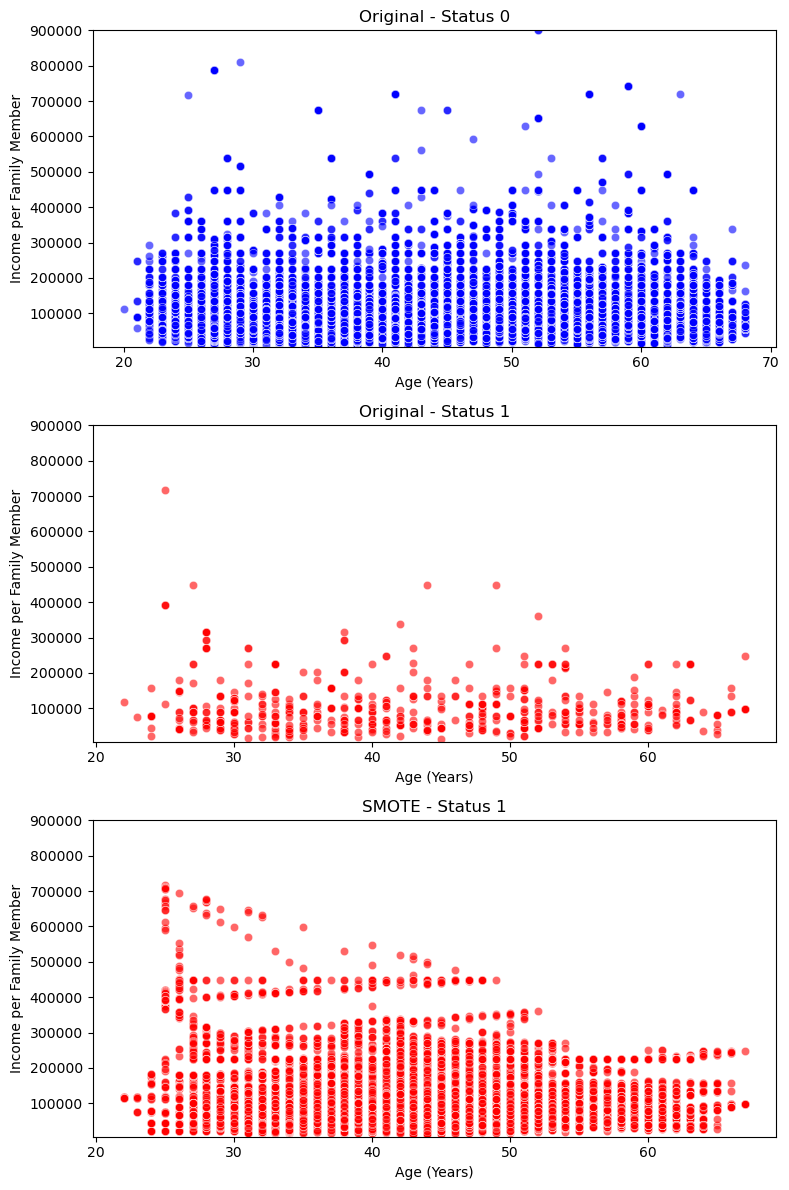

In [19]:
# Create a combined plot for original statuses 0 and 1, and SMOTE-applied status 1 in a single column layout
plt.figure(figsize=(8, 12))

# Identify common y-axis limits based on the entire dataset
common_y_limits = (df['INCOME_PER_FAM_MEMBER'].min(), df['INCOME_PER_FAM_MEMBER'].max())
common_y_limits_smote = (X_res['INCOME_PER_FAM_MEMBER'].min(), X_res['INCOME_PER_FAM_MEMBER'].max())

# Original data scatterplot for status 0
plt.subplot(3, 1, 1)
sns.scatterplot(
    data=df[df['STATUS'] == 0],
    x='YEARS_BIRTH',
    y='INCOME_PER_FAM_MEMBER',
    alpha=0.6,
    color="blue"
)
plt.ylim(common_y_limits)
plt.title('Original - Status 0')
plt.xlabel('Age (Years)')
plt.ylabel('Income per Family Member')

# Original data scatterplot for status 1
plt.subplot(3, 1, 2)
sns.scatterplot(
    data=df[df['STATUS'] == 1],
    x='YEARS_BIRTH',
    y='INCOME_PER_FAM_MEMBER',
    alpha=0.6,
    color="red"
)
plt.ylim(common_y_limits)
plt.title('Original - Status 1')
plt.xlabel('Age (Years)')
plt.ylabel('Income per Family Member')

# SMOTE data scatterplot for status 1
plt.subplot(3, 1, 3)
sns.scatterplot(
    data=X_res[y_res == 1],
    x='YEARS_BIRTH',
    y='INCOME_PER_FAM_MEMBER',
    alpha=0.6,
    color="red"
)
plt.ylim(common_y_limits_smote)
plt.title('SMOTE - Status 1')
plt.xlabel('Age (Years)')
plt.ylabel('Income per Family Member')

plt.tight_layout()
plt.show()

#### Train-Test Split

Split the resampled dataset into training and testing sets (80/20), using stratification to preserve class ratios.
Sample weights are also split accordingly.


In [20]:
# Perform the train-test split
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X_res, y_res, sample_weights_resampled, test_size=0.2, random_state=42, stratify=y_res)

# Display the resulting dataset sizes
print(f"Train set size: {X_train.shape, y_train.shape}")
print(f"Test set size: {X_test.shape, y_test.shape}")

Train set size: ((57345, 17), (57345,))
Test set size: ((14337, 17), (14337,))


## Train Models

We train three classification models:
- Random Forest
- LightGBM
- XGBoost

Each model is trained using sample weights to improve generalization, especially for important groups.


## Make Predictions

Using the test set, we make predictions with each of the three trained models to prepare for evaluation.


## Model Evaluation

We evaluate each model using:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**

These metrics help assess overall performance and identify trade-offs.

In [21]:
# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Train the LightGBM model
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Train the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Predict on the test set using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Predict on the test set using LightGBM
y_pred_lgb = lgb_model.predict(X_test)

# Predict on the test set using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

# Evaluate the LightGBM model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
report_lgb = classification_report(y_test, y_pred_lgb)

# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

# Print the results
print("Random Forest Results:")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:")
print(report_rf)

print("\nLightGBM Results:")
print(f"Accuracy: {accuracy_lgb}")
print("Classification Report:")
print(report_lgb)

print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:")
print(report_xgb)

[LightGBM] [Info] Number of positive: 28673, number of negative: 28672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3157
[LightGBM] [Info] Number of data points in the train set: 57345, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664729 -> initscore=0.684442
[LightGBM] [Info] Start training from score 0.684442


c:\Users\Mateusz\miniconda3\envs\od_zera_do_ai_3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:18:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random Forest Results:
Accuracy: 0.9873753225918951
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7169
           1       0.98      0.99      0.99      7168

    accuracy                           0.99     14337
   macro avg       0.99      0.99      0.99     14337
weighted avg       0.99      0.99      0.99     14337


LightGBM Results:
Accuracy: 0.9739136499965125
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7169
           1       0.97      0.98      0.97      7168

    accuracy                           0.97     14337
   macro avg       0.97      0.97      0.97     14337
weighted avg       0.97      0.97      0.97     14337


XGBoost Results:
Accuracy: 0.9821441026714096
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7169
           1       0.

#### Feature Importance

We visualize which features were most important to each model's decisions. This can give insights into:
- Which features drive predictions
- Possible biases in the data


#### Confusion Matrices

Visual representations of model performance, showing:
- True positives/negatives
- False positives/negatives

This helps evaluate how well the model distinguishes between classes.


C:\Users\Mateusz\AppData\Local\Temp\ipykernel_22452\2024139784.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_rf[sorted_idx_rf], y=X_train.columns[sorted_idx_rf], palette="Blues_d")


NameError: name 'importances_lgb' is not defined

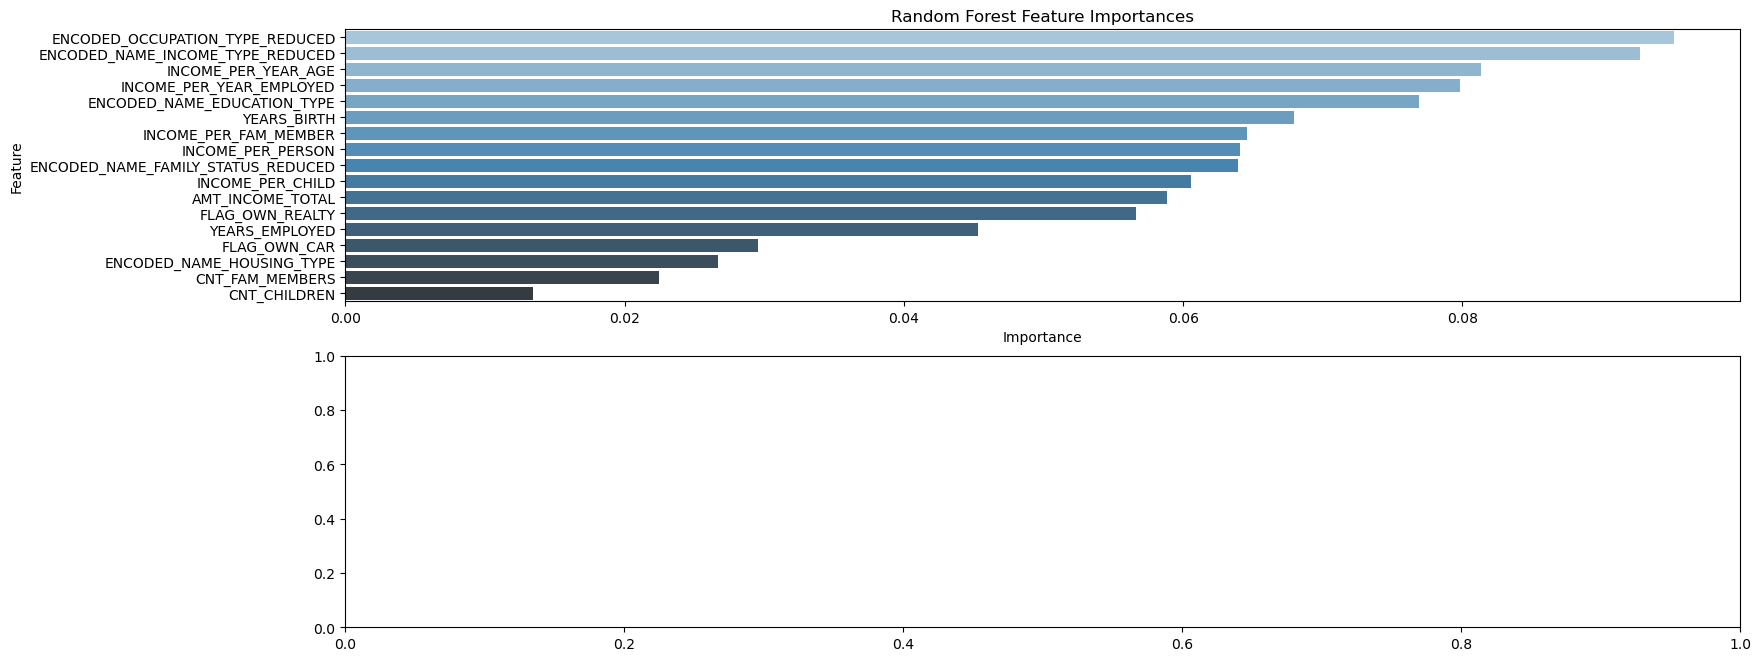

In [24]:
# Plot feature importances for all models
plt.figure(figsize=(18, 12))

# Random Forest feature importances
plt.subplot(3, 1, 1)
importances_rf = rf_model.feature_importances_
sorted_idx_rf = importances_rf.argsort()[::-1]  # Descending order
sns.barplot(x=importances_rf[sorted_idx_rf], y=X_train.columns[sorted_idx_rf], palette="Blues_d")
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# LightGBM feature importances
plt.subplot(3, 1, 2)
sorted_idx_lgb = importances_lgb.argsort()[::-1]  # Descending order
sns.barplot(x=importances_lgb[sorted_idx_lgb], y=X_train.columns[sorted_idx_lgb], palette="Greens_d")
plt.title('LightGBM Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# XGBoost feature importances
plt.subplot(3, 1, 3)
sorted_idx_xgb = importances_xgb.argsort()[::-1]  # Descending order
sns.barplot(x=importances_xgb[sorted_idx_xgb], y=X_train.columns[sorted_idx_xgb], palette="Reds_d")
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=['Class 0', 'Class 1'], cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')

# LightGBM
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgb, display_labels=['Class 0', 'Class 1'], cmap='Greens', ax=axes[1])
axes[1].set_title('LightGBM Confusion Matrix')

# XGBoost
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels=['Class 0', 'Class 1'], cmap='Reds', ax=axes[2])
axes[2].set_title('XGBoost Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
# Create the directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Train RandomForest model on the entire dataset
rf_model_full = RandomForestClassifier(random_state=42)
rf_model_full.fit(X, y, sample_weight=sample_weights)
joblib.dump(rf_model_full, 'models/rf_smote.pkl')

# Train LightGBM model on the entire dataset
lgb_model_full = LGBMClassifier(random_state=42)
lgb_model_full.fit(X, y, sample_weight=sample_weights)
joblib.dump(lgb_model_full, 'models/lgb_smote.pkl')

# Train XGBoost model on the entire dataset
xgb_model_full = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_full.fit(X, y, sample_weight=sample_weights)
joblib.dump(xgb_model_full, 'models/xgb_smote.pkl')

print("Models saved at: \nrf_smote.pkl\nlgb_smote.pkl\nxgb_smote.pkl")

In [ ]:
# --- Load Trained Model ---
model = joblib.load('models/rf_smote.pkl')

# --- Encoding Maps ---
education_map = {
    'Academic degree': 0.0005,
    'Higher education': 0.0173,
    'Incomplete higher': 0.0234,
    'Lower secondary': 0.0267,
    'Secondary / secondary special': 0.0162
}

housing_map = {
    'Co-op apartment': 0.0179,
    'House / apartment': 0.0166,
    'Municipal apartment': 0.0266,
    'Office apartment': 0.0343,
    'Rented apartment': 0.0139,
    'With parents': 0.0146
}

income_type_map = {
    'Commercial associate': 0.0168,
    'Other': 0.0014,
    'Pensioner': 0.0211,
    'State servant': 0.0124,
    'Working': 0.0163
}

family_status_map = {
    'Civil marriage': 0.0156,
    'Married': 0.0157,
    'Separated': 0.0147,
    'Single / not married': 0.0209,
    'Widow': 0.0294
}

occupation_map = {
    'Accountants': 0.0185,
    'Cleaning staff': 0.0091,
    'Cooking staff': 0.0137,
    'Core staff': 0.0206,
    'Drivers': 0.0229,
    'High skill tech staff': 0.0217,
    'Laborers': 0.0169,
    'Managers': 0.0157,
    'Medicine staff': 0.0083,
    'Other': 0.0221,
    'Private service staff': 0.0058,
    'Sales staff': 0.0128,
    'Security staff': 0.022
}

# --- User Inputs ---
flag_own_car = 0
flag_own_realty = 1
cnt_children = 0
amt_income_total = 219000
cnt_fam_members = 1
years_birth = 43
years_employed = 17

education_type ='Higher education'
housing_type = 'House / apartment'
income_type = 'Working'
family_status = 'Married'
occupation_type =   'Accountants'

# --- Feature Engineering ---
income_per_person = amt_income_total / max(cnt_fam_members, 1)
income_per_child = amt_income_total / max(cnt_children, 1) if cnt_children > 0 else 0
low_income_flag = int((income_per_person < 20000) and (income_per_child < 50000))
income_per_fam_member = amt_income_total / max(cnt_fam_members, 1)
income_per_year_age = amt_income_total / max(years_birth, 1)
income_per_year_employed = amt_income_total / max(years_employed, 1)

# --- Data Preparation ---
df_input = pd.DataFrame([{
    'FLAG_OWN_CAR': flag_own_car,
    'FLAG_OWN_REALTY': flag_own_realty,
    'CNT_CHILDREN': cnt_children,
    'AMT_INCOME_TOTAL': amt_income_total,
    'CNT_FAM_MEMBERS': cnt_fam_members,
    'YEARS_BIRTH': years_birth,
    'YEARS_EMPLOYED': years_employed,
    'ENCODED_NAME_EDUCATION_TYPE': education_map[education_type],
    'ENCODED_NAME_HOUSING_TYPE': housing_map[housing_type],
    'ENCODED_NAME_INCOME_TYPE_REDUCED': income_type_map[income_type],
    'ENCODED_NAME_FAMILY_STATUS_REDUCED': family_status_map[family_status],
    'ENCODED_OCCUPATION_TYPE_REDUCED': occupation_map[occupation_type],
    'INCOME_PER_PERSON': income_per_person,
    'INCOME_PER_CHILD': income_per_child,
    'INCOME_PER_FAM_MEMBER': income_per_fam_member,
    'INCOME_PER_YEAR_AGE': income_per_year_age,
    'INCOME_PER_YEAR_EMPLOYED': income_per_year_employed
}])

# Rearrange columns to match the order of features used during training
# Note: The exact order depends on how the model was trained.

# --- Adjust Probability with Custom Penalties and Boosts ---
approval_prob = prediction_proba[0]

# Penalty 1: Low income
if (income_per_person < 20000) or (income_per_child < 50000):
    approval_prob -= 0.50

# Penalty 2: Penalized occupations
penalized_occupations = ['Cleaning staff', 'Laborers', 'Cooking staff', 'Other']
if occupation_type in penalized_occupations:
    approval_prob -= 0.10

# Penalty 3: Penalized education
penalized_education = ['Lower secondary', 'Secondary / secondary special']
if education_type in penalized_education:
    approval_prob -= 0.10

# Penalty 4: Penalized housing types
penalized_housing = ['Co-op apartment', 'Municipal apartment']
if housing_type in penalized_housing:
    approval_prob -= 0.10

# Boost 1: High income bonus
if (income_per_person > 100000) or (income_per_child > 100000):
    approval_prob += 0.50

# Clamp and normalize
approval_prob = max(0.0, min(1.0, approval_prob))
decline_prob = 1.0 - approval_prob

# Final decision
result = "Approved" if approval_prob >= 0.5 else "Declined"

# --- Output ---
print(f"Prediction: {result}")
print(f"Adjusted Probability of approval: {approval_prob:.2f}")
print(f"Adjusted Probability of decline: {decline_prob:.2f}")
df_input